## Getting ready

### `import` statements

Here we load functionality that isn't part of base Python from third-party packages. A couple of packages may look unfamiliar—in fact they're built into the DICES client, so we've been using them all along. But in this case we're not using DICES, so we have to import them explicitly.

In particular, we're using [MyCapytain](https://github.com/Capitains/MyCapytain) to talk to the CTS endpoint of the Perseus Digital Library, and [SpaCy](https://spacy.io/) to perform NLP on the Latin texts.

In [1]:
# provides CTS protocol
from MyCapytain.resolvers.cts.api import HttpCtsResolver
from MyCapytain.retrievers.cts5 import HttpCtsRetriever

# provides support for regular expressions
import re

# provides natural language processing
import spacy

# provides structures for tabular data
import pandas as pd

### Define constants

These are settings that control the way the rest of the script works; I like to define them at the beginning and make them all capital letters so they're easy to see. If we decide to change them later—if we want to use a different language model or a different digital library—we know where to look.

**language model**: In order to use SpaCy on our text, we need to plug in a trained language model. Here we're using one trained by Patrick Burns called `la_core_web_sm`. Patrick's [LatinCy](https://huggingface.co/latincy) project includes a full set of models with different strengths. I've chosen the smallest one to make this demo more accessible; if you want more accurate results, you'll have to install and load one of the larger models.

**CTS endpoint**: This is the remote server that will receive our requests for Latin texts and, if all goes well, send those texts back to us. The one I've chosen is associated with Perseus 5; it's essentially a machine-oriented counterpart to the human-oriented interface called the [Scaife Viewer](https://scaife.perseus.org/).

In [2]:
# language model
LATIN_MODEL = 'la_core_web_sm'

# CTS endpoint for Perseus
CTS_SERVER = 'https://scaife-cts.perseus.org/api/cts'

### Input data

These are the texts I want to work with. Again, I'm putting them at the start of the script so that I can find and potentially change them later, depending on how the experiment works out. It might make even more sense—especially if there were more—to put them in a separate data file.

Each row describes one text. The first column is the machine-readable CTS URN for the text. I got these by looking up the works in the [Perseus Catalog](https://catalog.perseus.org/). These URNs refer to the texts in the abstract, without specifying a particular edition. The CTS server will decide what edition to give me based on what it has available—to better control this experiment, I would use URNs for particular editions.

In [3]:
DATA = [
    ('urn:cts:latinLit:phi1017.phi001',   'Seneca',   'Herc_Fur'),
    ('urn:cts:latinLit:phi1017.phi009',   'Seneca',   'Herc_Oet'),
    ('urn:cts:latinLit:phi1017.phi004',   'Seneca',   'Medea'),
    ('urn:cts:latinLit:phi1017.phi006',   'Seneca',   'Oedipus'),
    ('urn:cts:latinLit:phi1017.phi005',   'Seneca',   'Phaedra'),
    ('urn:cts:latinLit:phi1017.phi003',   'Seneca',   'Phoenissae'),
    ('urn:cts:latinLit:phi1017.phi008',   'Seneca',   'Thyestes'),
    ('urn:cts:latinLit:phi1017.phi002',   'Seneca',   'Troades'),
    ('urn:cts:latinLit:phi1035.phi001:1', 'Val_Flac', 'Thebaid_01'),
    ('urn:cts:latinLit:phi1035.phi001:2', 'Val_Flac', 'Thebaid_02'),
    ('urn:cts:latinLit:phi1035.phi001:3', 'Val_Flac', 'Thebaid_03'),
    ('urn:cts:latinLit:phi1035.phi001:4', 'Val_Flac', 'Thebaid_04'),
    ('urn:cts:latinLit:phi1035.phi001:5', 'Val_Flac', 'Thebaid_05'),
    ('urn:cts:latinLit:phi1035.phi001:6', 'Val_Flac', 'Thebaid_06'),
    ('urn:cts:latinLit:phi1035.phi001:7', 'Val_Flac', 'Thebaid_07'),
    ('urn:cts:latinLit:phi1035.phi001:8', 'Val_Flac', 'Thebaid_08'),
]

### Read the data

Here we'll read through the input data and create structured records for the texts. I'm going to use a dictionary to represent each one, so that all the information is clearly labelled, and so that it's easy to add new attributes to each record as we go along.

In [4]:
# create an empty list
records = []

# iterate over the data
for row in DATA:
    
    # read in the information
    urn, author, title = row
    
    # structure it as a dictionary
    rec = dict(
        urn = urn,
        author = author,
        title = title,
    )
    
    # add it to the list
    records.append(rec)

#### Did it work?

Let's print them all out, just to check that it worked. Since they're dictionaries, we can wrap the in a Pandas data frame for a nicely formatted table.

In [5]:
pd.DataFrame(records)

,urn,author,title
0,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur
1,urn:cts:latinLit:phi1017.phi009,Seneca,Herc_Oet
2,urn:cts:latinLit:phi1017.phi004,Seneca,Medea
3,urn:cts:latinLit:phi1017.phi006,Seneca,Oedipus
4,urn:cts:latinLit:phi1017.phi005,Seneca,Phaedra
5,urn:cts:latinLit:phi1017.phi003,Seneca,Phoenissae
6,urn:cts:latinLit:phi1017.phi008,Seneca,Thyestes
7,urn:cts:latinLit:phi1017.phi002,Seneca,Troades
8,urn:cts:latinLit:phi1035.phi001:1,Val_Flac,Thebaid_01
9,urn:cts:latinLit:phi1035.phi001:2,Val_Flac,Thebaid_02


### Initialize CTS connection

Here we use MyCapytain to create a connection to the CTS server and assign it to a name so we can use it later.

In [6]:
cts_resolver = HttpCtsResolver(HttpCtsRetriever(CTS_SERVER))

### Initialize SpaCy

Here we load the Latin language model and create a new instance of SpaCy's NLP processing pipeline. Once again, we need to assign this to a name so that we can use it later to process the texts.

In [7]:
spacy_nlp = spacy.load(LATIN_MODEL)

## Downloading and processing the texts

### Download the texts from Perseus

Here we iterate over all our records and use `cts_resolver`, the connection to Perseus that we initialized above, to request each text in turn by its URN. The method `getTextualNode()` makes the request for text.

In [8]:
# iterate over the records and count them off
for i, rec in enumerate(records):
    
    # show progress
    print(f'[{i+1}/{len(records)}]', end=' ')
    
    # try to download the text by urn
    cts_passage = cts_resolver.getTextualNode(rec['urn'])
    
    # see whether it worked
    if cts_passage is not None:
        print(len(cts_passage.text), 'bytes')
    else:
        print('failed')
        
    # add to the record
    rec['cts'] = cts_passage

[1/16] 51899 bytes
[2/16] 75756 bytes
[3/16] 38838 bytes
[4/16] 40509 bytes
[5/16] 49098 bytes
[6/16] 27283 bytes
[7/16] 42468 bytes
[8/16] 46414 bytes
[9/16] 53770 bytes
[10/16] 41646 bytes
[11/16] 45921 bytes
[12/16] 45621 bytes
[13/16] 43163 bytes
[14/16] 48480 bytes
[15/16] 43982 bytes
[16/16] 28689 bytes


### Inspect the results

Let's take a look at what we got. We'll start by examining the first play, *Hercules Furens*.

In [9]:
# select the first record
rec = records[0]

What did Perseus give us? The results of our request are stored under the key `cts`. Let's just print it to the screen:

In [10]:
print(rec['cts'])

<TEI xmlns="http://www.tei-c.org/ns/1.0"><teiHeader><fileDesc><titleStmt><title>Hercules Furens</title><author n="Sen.">Seneca</author><editor role="editor" n="Peiper">Rudolf Peiper</editor><editor role="editor" n="Richter">Gustav Richter</editor><sponsor>Perseus Project, Tufts University</sponsor><principal>Gregory Crane</principal><respStmt><resp>Prepared under the supervision of</resp><name>Bridget Almas</name><name>Lisa Cerrato</name><name>David Mimno</name><name>Rashmi Singhal</name></respStmt><funder n="org:NEH">The National Endowment for the Humanities</funder></titleStmt><extent>About 100Kb</extent><publicationStmt><publisher>Trustees of Tufts University</publisher><pubPlace>Medford, MA</pubPlace><authority>Perseus Project</authority><date type="release">2009-10-07</date></publicationStmt><sourceDesc><biblStruct><monogr><author>L. Annaeus Seneca</author><title>Tragoediae</title><editor role="editor" n="Peiper">Rudolf Peiper</editor><editor role="editor" n="Richter">Gustav Richt

By default, it's represented as **TEI XML**. In fact, what we have is a somewhat complicated Python object, with a number of attributes and methods attached to it. One simple attribute is `text`, which gives us just the text of the passage, without the XML markup:

In [11]:
print(rec['cts'].text)

Hercules Furens Seneca Rudolf Peiper Gustav Richter Perseus Project, Tufts University Gregory Crane Prepared under the supervision of Bridget Almas Lisa Cerrato David Mimno Rashmi Singhal The National Endowment for the Humanities About 100Kb Trustees of Tufts University Medford, MA Perseus Project 2009-10-07 L. Annaeus Seneca Tragoediae Rudolf Peiper Gustav Richter Leipzig Teubner 1921 Internet Archive Hercules Lycus Amphitryon Iuno Theseus Megara Chorus Thebanorum This pointer pattern extracts line Latin Tagging New URN, Epidoc and CTS Iuno Soror Tonantis (hoc enim solum mihi nomen relictum est) semper alienum Iovem ac templa summi vidua deserui aetheris locumque caelo pulsa paelicibus dedi; tellus colenda est: paelices caelum tenent, hinc Arctos alta parte glacialis poli sublime classes sidus Argolicas agit; hinc, qua tepenti vere labatur dies, Tyriae per undas vector Europae nitet; illinc timendum ratibus ac ponto gregem passim vagantes exerunt Atlantides. ferro minax hinc terret Or

Now all the tags are gone and we're looking at Latin. But there's still some extra material here.
- For one thing, the front matter is included—the title of the book, some information about who encoded it, etc. 
- For another, if you look closely, you'll see that the speaker names are also included. This edition is formatted the way we would a modern play, with each speaker identified at the beginning of their lines. So you see abbreviated names (**Amph.**, **Meg.**, etc.) peppered throughout the text.

I wonder if there's an easy way to exclude these.

#### TEI XML

Look back at the XML above for a moment. Notice that each line of the text is enclosed by `<l></l>` tags. The speaker names, on the other hand, are in `<speaker></speaker>` tags, outside of the `<l></l>`. Each group of consecutive lines spoken by one character is enclosed in `<sp></sp>`. For example:

```xml
<sp who="#megara">
    <speaker>Meg.</speaker>
    <l n="313b" part="F">Quod nimis miseri volunt</l>
    <l n="314" part="I">hoc facile credunt,</l>
</sp>
```

It looks like metrical lines that are broken across multiple speakers are being handled in a somewhat complicated way, here, but luckily that's not our concern for the moment.

#### Selecting certain XML elements

For our purposes, I think that if we could extract only the `<l></l>` elements, we would have all the Latin words of the play and none, or at least much less, of the paratext.

Luckily, the CTS object that we got from MyCapytains has an `xml` attribute that exposes the underlying XML structure, and Python tools exist to help us traverse that structure using [XPath](https://en.wikipedia.org/wiki/XPath), a language for describing XML. 

In brief, the XPath expression referring to "all the <l> elements at any level of the current document" is `'.//l'`. We can use this with the `findall()` method to pull out a list of all the lines.
    
**Caveat**: this is slightly complicated by the fact that this XML uses **namespaces**, a set of prefixes that qualify certain tags. So we need to pull the namespace map from the document first and feed that back into our `findall()` in order to get the tags we want.

In [12]:
# first retrieve the namespaces for this document
ns = rec['cts'].xml.nsmap

# now search for <l> tags
lines = rec['cts'].xml.findall('.//l', namespaces=ns)

#### Did it work?

Let's print out all the `<l></l>` elements we pulled from *Hercules Furens*, to see whether the results look like what we want.

Each line has its line number recorded as an XML **attribute** called `n`, as in `<l n="313b">` above. We can access these using the `get()` method of each line. Then we'll get the text of each line using `.text`, just as we did for the document as a whole earlier.

In [13]:
for l in lines:
    print(l.get('n'), l.text)

1 Soror Tonantis (hoc enim solum mihi
2 nomen relictum est) semper alienum Iovem
3 ac templa summi vidua deserui aetheris
4 locumque caelo pulsa paelicibus dedi;
5 tellus colenda est: paelices caelum tenent,
6 hinc Arctos alta parte glacialis poli
7 sublime classes sidus Argolicas agit;
8 hinc, qua tepenti vere labatur dies,
9 Tyriae per undas vector Europae nitet;
10 illinc timendum ratibus ac ponto gregem 
11 passim vagantes exerunt Atlantides.
12 ferro minax hinc terret Orion deos
13 suasque Perseus aureus stellas habet;
14 hinc clara gemini signa Tyndaridae micant
15 quibusque natis mobilis tellus stetit. 
16 nec ipse tantum Bacchus aut Bacchi parens
17 adiere superos: ne qua pars probro vacet,
18 mundus puellae serta Gnosiacae gerit,
19 sed vetera sero querimur 
19b None
20 Thebana tellus nuribus a! sparsa impiis 
21 quotiens novercam fecit! escendat licet
22 meumque victrix teneat Alcmene locum,
23 pariterque natus astra promissa occupet,
24 in cuius ortus mundus impendit diem
25

Hooray—the text looks much cleaner than before!

### Join the lines into a single string

Perhaps for some future work we'll want all the lines individually like this, but for now I'm going to paste them all together. We'll use Python's `str.join()` method and a list comprehension. To make the text easier for humans to read, I'm going to join on the newline; I don't think SpaCy will mind.

🤔 Oops! This is what I tried:

```python
print('\n'.join([l.text for l in lines]))
```

And this is what I got:

<div style="margin-top:2em">
<pre>
<span class="ansi-red-fg">---------------------------------------------------------------------------</span>
<span class="ansi-red-fg">TypeError</span>                                 Traceback (most recent call last)
Cell <span class="ansi-green-fg">In[14], line 1</span>
<span class="ansi-green-fg">----&gt; 1</span> <span style="color: rgb(0,135,0)">print</span>(<span class="ansi-yellow-bg" style="color: rgb(175,0,0)">'</span><span class="ansi-yellow-bg ansi-bold" style="color: rgb(175,95,0)">\n</span><span class="ansi-yellow-bg" style="color: rgb(175,0,0)">'</span><span class="ansi-yellow-bg" style="color: rgb(98,98,98)">.</span><span class="ansi-yellow-bg">join</span><span class="ansi-yellow-bg">(</span><span class="ansi-yellow-bg">[</span><span class="ansi-yellow-bg">l</span><span class="ansi-yellow-bg" style="color: rgb(98,98,98)">.</span><span class="ansi-yellow-bg">text</span><span class="ansi-yellow-bg"> </span><span class="ansi-yellow-bg ansi-bold" style="color: rgb(0,135,0)">for</span><span class="ansi-yellow-bg"> </span><span class="ansi-yellow-bg">l</span><span class="ansi-yellow-bg"> </span><span class="ansi-yellow-bg ansi-bold" style="color: rgb(175,0,255)">in</span><span class="ansi-yellow-bg"> </span><span class="ansi-yellow-bg">lines</span><span class="ansi-yellow-bg">]</span><span class="ansi-yellow-bg">)</span>)

<span class="ansi-red-fg">TypeError</span>: sequence item 19: expected str instance, NoneType found
</pre>
</div>

At least some of the lines have no text, it seems. That probably deserves some investigation, but for now I'm just going to leave those ones out by adding an `if` clause to the end of my list comprehension.

This should fix the problem:

In [14]:
print('\n'.join([l.text for l in lines if l.text is not None]))

Soror Tonantis (hoc enim solum mihi
nomen relictum est) semper alienum Iovem
ac templa summi vidua deserui aetheris
locumque caelo pulsa paelicibus dedi;
tellus colenda est: paelices caelum tenent,
hinc Arctos alta parte glacialis poli
sublime classes sidus Argolicas agit;
hinc, qua tepenti vere labatur dies,
Tyriae per undas vector Europae nitet;
illinc timendum ratibus ac ponto gregem 
passim vagantes exerunt Atlantides.
ferro minax hinc terret Orion deos
suasque Perseus aureus stellas habet;
hinc clara gemini signa Tyndaridae micant
quibusque natis mobilis tellus stetit. 
nec ipse tantum Bacchus aut Bacchi parens
adiere superos: ne qua pars probro vacet,
mundus puellae serta Gnosiacae gerit,
sed vetera sero querimur 
Thebana tellus nuribus a! sparsa impiis 
quotiens novercam fecit! escendat licet
meumque victrix teneat Alcmene locum,
pariterque natus astra promissa occupet,
in cuius ortus mundus impendit diem
tardusque Eoo Phoebus effulsit mari 
retinere mersum iussus Oceano iubar.


### What about Valerius Flaccus?

Now that I'm pretty sure I've got a method that works for Seneca's tragedies, what about the epic texts? Let's look at book 1 of the *Argonautica* to see whether the XML is laid out in a similar fashion.

In [15]:
rec = records[8]
print(rec['cts'])

<TEI xmlns="http://www.tei-c.org/ns/1.0" xmlns:py="http://codespeak.net/lxml/objectify/pytype" py:pytype="TREE"><text><body><div type="edition" n="urn:cts:latinLit:phi1035.phi001.perseus-lat2" xml:lang="lat"><div type="textpart" subtype="book" n="1"><head>C. Valeri Flacci Argonauticon Liber Primus.</head><milestone unit="card" n="1"/><milestone unit="para"/><l n="1">Prima deum magnis canimus freta pervia natis<note place="unspecified" anchored="true">natis <hi rend="italics">N,</hi> nautis <hi rend="italics">V</hi>
                  </note>
               </l><l n="2">fatidicamque ratem, Scythici quae Phasidis oras</l><l n="3">ausa sequi mediosque inter iuga concita cursus</l><l n="4">rumpere flammifero tandem consedit Olympo.</l><milestone unit="line" ed="exclude" n="5"/><l n="5">Phoebe, mone, si Cymaeae mihi conscia vatis</l><l n="6">stat casta cortina domo, si laurea digna</l><l n="7">fronte viret; tuque o, pelagi cui maior aperti</l><l n="8">fama, Caledonius postquam tua carbasa ve

At a glance, it looks like all the verse lines are enclosed in `<l></l>` tags, just as in Seneca. One thing that stands out to me is that there seem to be a lot of `<note></note>` elements throughout the text. We'll have to see how those affect results.

Let's try iterating over all the lines using the same method we used for Seneca and see what we get.

In [16]:
ns = rec['cts'].xml.nsmap
lines = rec['cts'].xml.findall('.//l', namespaces=ns)

for l in lines:
    print(l.get('n'), l.text)

1 Prima deum magnis canimus freta pervia natis
2 fatidicamque ratem, Scythici quae Phasidis oras
3 ausa sequi mediosque inter iuga concita cursus
4 rumpere flammifero tandem consedit Olympo.
5 Phoebe, mone, si Cymaeae mihi conscia vatis
6 stat casta cortina domo, si laurea digna
7 fronte viret; tuque o, pelagi cui maior aperti
8 fama, Caledonius postquam tua carbasa vexit
9 Oceanus Phrygios prius indignatus Iulos,
10 eripe me populis et habenti
11 sancte pater, veterumque fave veneranda canenti
12 facta virum. versam proles tua pandet
13 (namque potest
14 spargentemque faces et in omni turre furentem.
15 ille tibi cultusque deum delubraque gentis
16 instituet, cum tu,
17 parte poli, neque iam
18 certior aut Grais Helice servanda magistris,
19 sed tu signa dabis, sed
20 et Sidon Nilusque rates. nunc nostra serenus
21 orsa iuves, haec ut Latias vox impleat urbes.
22 Haemoniam
23 iam gravis et longus populis metus:
24 Ionium quicumque petunt, ille Othryn et Haemum
25 atque imum felix vers

🤔 Hmm... I don't see any obvious intrusion from the `<note></note>` elements, but there are some weirdly short lines here, and at least one `None`. I think I'd better look at the XML and just see what's going on here.

What's up with line 13, for example? Here's how it appears in the [Scaife Viewer](https://scaife.perseus.org/reader/urn:cts:latinLit:phi1035.phi001.perseus-lat2:1.1-1.30/):

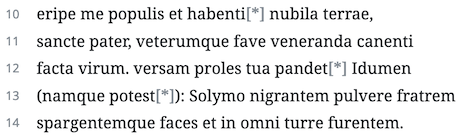

We're clearly missing text—it seems that everything after the first `<note></note>` in a line is being lost using our current method.

### A slightly more sophisticated method for extracting text

It looks like simply using the `l.text` attribute is not going to work for us. We're going to have to do two things.

- We're going to have to remove `<note></note>` elements from the `<l></l>` before extracting text
- We're going to have to put back the following (*[tail](https://docs.python.org/3/library/xml.etree.elementtree.html#xml.etree.ElementTree.Element.tail)*) text after each `<note></note>`.

For the sake of brevity, here's the way we do it inside the DICES client. The steps are complicated enough that I'm going to wrap the whole thing in a **function definition**: I'm giving this code a name so that I can reuse it later, just like Python's built-in functions.

In [17]:
def cleanLine(l):
    '''Extract the text of a TEI line element'''
    
    # look for notes
    for note in l.findall('note', namespaces=l.nsmap):
        
        # remove, keeping tail text
        note.clear(keep_tail=True)
    
    # paste together all text elements in the line
    text = ' '.join(l.itertext())
    
    # get rid of any extra whitespace
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    
    # return the result
    return text

Let's try it out:

In [18]:
ns = rec['cts'].xml.nsmap
lines = rec['cts'].xml.findall('.//l', namespaces=ns)

for l in lines:    
    print(l.get('n'), cleanLine(l))

1 Prima deum magnis canimus freta pervia natis
2 fatidicamque ratem, Scythici quae Phasidis oras
3 ausa sequi mediosque inter iuga concita cursus
4 rumpere flammifero tandem consedit Olympo.
5 Phoebe, mone, si Cymaeae mihi conscia vatis
6 stat casta cortina domo, si laurea digna
7 fronte viret; tuque o, pelagi cui maior aperti
8 fama, Caledonius postquam tua carbasa vexit
9 Oceanus Phrygios prius indignatus Iulos,
10 eripe me populis et habenti nubila terrae,
11 sancte pater, veterumque fave veneranda canenti
12 facta virum. versam proles tua pandet Idumen
13 (namque potest ): Solymo nigrantem pulvere fratrem
14 spargentemque faces et in omni turre furentem.
15 ille tibi cultusque deum delubraque gentis
16 instituet, cum tu, genitor, lucebis ab omni
17 parte poli, neque iam Tyriis Cynosura carinis
18 certior aut Grais Helice servanda magistris,
19 sed tu signa dabis, sed te duce Graecia mittet
20 et Sidon Nilusque rates. nunc nostra serenus
21 orsa iuves, haec ut Latias vox impleat urb

🎉 Huzzah! This looks pretty good to me. Line 45 is missing—I took a look [on Perseus](https://scaife.perseus.org/reader/urn:cts:latinLit:phi1035.phi001.perseus-lat2:1.31-1.60) and it appears as an elipsis there, too. In the XML, it looks like this:

```xml
<l n="45"><gap reason="omitted"/></l>
```

So I think things are working the way they should here.


### Extract the text of all the works

Now we can go through the whole list of records and extract just the text, using our newly-refined method. It took some time to get here, but it was worth it! Now we don't have extra stuff in the output, nor are we missing words that should be there.

In [19]:
# iterate over the records and count them off
for i, rec in enumerate(records):
    
    # show progress
    print(f'[{i+1}/{len(records)}]', end=' ')
    
    # get the namespaces
    ns = rec['cts'].xml.nsmap
    
    # get the lines
    lines = rec['cts'].xml.findall('.//l', namespaces=ns)
    
    # extract the text and paste together
    text = '\n'.join(cleanLine(l) for l in lines)
    
    # print a status message
    print(len(text), 'bytes')
    
    # add to record
    rec['text'] = text

[1/16] 50457 bytes
[2/16] 74188 bytes
[3/16] 37588 bytes
[4/16] 39052 bytes
[5/16] 47805 bytes
[6/16] 26513 bytes
[7/16] 41074 bytes
[8/16] 44880 bytes
[9/16] 38601 bytes
[10/16] 30324 bytes
[11/16] 33643 bytes
[12/16] 34671 bytes
[13/16] 31684 bytes
[14/16] 34474 bytes
[15/16] 29697 bytes
[16/16] 21490 bytes


### Process the text with SpaCy

Now that we have the text, we can run NLP with SpaCy. Let's try *Hercules Furens* first, to see how it goes.

In [20]:
# select the first record
rec = records[0]

# run spacy on the text
spacy_doc = spacy_nlp(rec['text'])

### Did it work?

Let's look at the first couple of tokens just to see whether the results make sense.

In [21]:
# iterate over 25 tokens
for i, token in enumerate(spacy_doc[:25]):
    print(i, token)

0 Soror
1 Tonantis
2 (
3 hoc
4 enim
5 solum
6 mihi
7 

8 nomen
9 relictum
10 est
11 )
12 semper
13 alienum
14 Iovem
15 

16 ac
17 templa
18 summi
19 vidua
20 deserui
21 aetheris
22 

23 locum
24 que


🤔 Hmm... Looks like I was overly optimistic in assuming SpaCy would ignore the line breaks. I'm not sure whether it's really a problem for them to be counted as tokens. Let's poke a little further: what part of speech tag is SpaCy assigning to the line break tokens?

In [22]:
# iterate over 25 tokens
for i, token in enumerate(spacy_doc[:25]):
    print(i, token, token.pos_)

0 Soror PROPN
1 Tonantis PROPN
2 ( PUNCT
3 hoc DET
4 enim PART
5 solum ADV
6 mihi PRON
7 
 ADJ
8 nomen NOUN
9 relictum VERB
10 est AUX
11 ) PUNCT
12 semper ADV
13 alienum ADJ
14 Iovem PROPN
15 
 ADJ
16 ac CCONJ
17 templa NOUN
18 summi ADJ
19 vidua NOUN
20 deserui NOUN
21 aetheris ADJ
22 
 ADJ
23 locum NOUN
24 que CCONJ


🤔 No, this is no good. It's assigning different POS tags to the line breaks depending on what the surrounding tokens are. That is going to produce unpredictable results.

I'm going to replace all the linebreaks with spaces and re-run SpaCy.

In [23]:
# replace newlines with spaces
text = rec['text'].replace('\n', ' ')

# run spacy on the text
spacy_doc = spacy_nlp(text)

Now what do the tokens look like?

In [24]:
# iterate over 25 tokens
for i, token in enumerate(spacy_doc[:25]):
    print(i, token, token.pos_)

0 Soror PROPN
1 Tonantis PROPN
2 ( PUNCT
3 hoc DET
4 enim PART
5 solum ADV
6 mihi PRON
7 nomen NOUN
8 relictum VERB
9 est AUX
10 ) PUNCT
11 semper ADV
12 alienum ADJ
13 Iovem PROPN
14 ac CCONJ
15 templa NOUN
16 summi ADJ
17 vidua NOUN
18 deserui NOUN
19 aetheris ADJ
20 locum NOUN
21 que CCONJ
22 caelo NOUN
23 pulsa VERB
24 paelicibus VERB


I like that much better. Let's go ahead and do all the texts

### Process the text with SpaCy

Now we run NLP on each text in turn. This will create a SpaCy Doc object—we can treat it like a container of tokens. We'll use the same loop structure to process all the records, run SpaCy, and then save the results.

In [25]:
# iterate over the records and count them off
for i, rec in enumerate(records):
    
    # show progress
    print(f'[{i+1}/{len(records)}]', end=' ')
        
    # remove newlines
    text = rec['text'].replace('\n', ' ')
        
    # run spacy
    spacy_doc = spacy_nlp(text)
    
    # print status
    print(len(spacy_doc), 'tokens')
    
    # save to record
    rec['spacy_doc'] = spacy_doc

[1/16] 9082 tokens
[2/16] 13678 tokens
[3/16] 6908 tokens
[4/16] 6993 tokens
[5/16] 8560 tokens
[6/16] 4995 tokens
[7/16] 7481 tokens
[8/16] 8225 tokens
[9/16] 6823 tokens
[10/16] 5381 tokens
[11/16] 5904 tokens
[12/16] 6207 tokens
[13/16] 5669 tokens
[14/16] 6047 tokens
[15/16] 5468 tokens
[16/16] 3903 tokens


### Create a table

Now that we've tokenized all the texts, we can generate a giant table with one row per token, and one column for every feature we might be interested in.


#### Generate a list of rows as dictionaries

We'll create one row for every token using nested **for loop**: in the outer loop we iterate over all the records, and then for each record, we iterate over all the tokens in an inner loop.

In [26]:
# start with an empty list
rows = []

# iterate over all the records
for rec in records:
        
    # iterate over all the tokens
    for token in rec['spacy_doc']:
        
        # extract morphological features
        features = token.morph.to_dict()
        
        # create a new row
        row = dict(
            
            # text info
            urn = rec['urn'],
            author = rec['author'],
            title = rec['title'],
            
            # token info
            token = token.text,
            lemma = token.lemma_,
            upos = token.pos_,
            
            # specific morphological features
            mood = features.get('Mood'),
            tense = features.get('Tense'),
            voice = features.get('Voice'),
            person = features.get('Person'),
            number = features.get('Number'),
            case = features.get('Case'),
            gender = features.get('Gender'),
        )
        
        # add row to list
        rows.append(row)

#### Make the table with Pandas

In [27]:
table = pd.DataFrame(rows)
display(table)

,urn,author,title,token,lemma,upos,mood,tense,voice,person,number,case,gender
0,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,Soror,soror,PROPN,None,None,None,None,Sing,Nom,Masc
1,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,Tonantis,Tonantis,PROPN,None,None,None,None,Sing,Gen,Masc
2,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,(,(,PUNCT,None,None,None,None,None,None,None
3,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,hoc,hic,DET,None,None,None,None,Sing,Acc,Neut
4,urn:cts:latinLit:phi1017.phi001,Seneca,Herc_Fur,enim,enim,PART,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111319,urn:cts:latinLit:phi1035.phi001:8,Val_Flac,Thebaid_08,tibi,tu,PRON,None,None,None,None,Sing,Dat,None
111320,urn:cts:latinLit:phi1035.phi001:8,Val_Flac,Thebaid_08,praemia,praemium,NOUN,None,None,None,None,Plur,Acc,Neut
111321,urn:cts:latinLit:phi1035.phi001:8,Val_Flac,Thebaid_08,reddi,reddo,VERB,Inf,Pres,Pass,None,None,None,None
111322,urn:cts:latinLit:phi1035.phi001:8,Val_Flac,Thebaid_08,?,?,PUNCT,None,None,None,None,None,None,None


#### Export to CSV

In [28]:
table.to_csv('token_table.csv', index=False)